# Welcome to my Data Insights Hackathon!!!

## Motivation

This hackathon will take place over the time period of 10am – 6pm Saturday 5/20/2017 and 10am-5pm Sunday 5/21/2017 and will feature one participant, ME!!!

The goal of this hackathon is for me to create a public project to demonstrate both my understanding and enthusiasm for deep learning. Most people build their portfolios over their career and so there is no need for them to do this kind of hackathon unfortunately, the best examples of my work are under lock and key in the code bases of a large financial institution, so here we go!

# My Project – Deep Factors for Financial instruments

Part of my motivation for choosing this paper is that I believe it will be useful to have domain expertise in a topic in order to create something interesting given the short time frame. The project I have decided to undertake is roughly based on the paper Deep Portfolio Theory by _____ found here LINK. Very quickly, I will try to summarize the high level concepts of the paper in the simplest terms that I can. I will then explain how it fits into the academic literature, why I think it is important, how I have deviated from it, and highlight some things that went wrong.

Prior to this paper portfolios of stocks were create with something called markowitz portfolio optimization. This sounds fancy and Russian so immediately you think its is extremely difficult and only a mathematical magician could understand it. I assure you this is not the case. It is actually very simple and is based off the concept that if you have a bunch of stocks you want to pick a portfolio that trades off the between the potential returns of the stock (  :-) yeah lets make money!) and the risk of a stock (  : - ( Boo! I don’t want to lose money). In order to assess what a stocks return is this clever Russian simply took the average of each stocks’ returns over some time period. To assess the risk portion of the equation he took the variance of the stocks returns. So simply put he looked at how much the stocks went up/down and he looked at how much the wiggled around before during the time they were going up/down. The really smart thing that Markowitz did was that he proved that it may be a good idea to include stocks with very small returns (maybe even negative)  in your portfolio to generate a better portfolio. This blew people away because it is not immediately intuitive to do this. The way this makes sense though is because, if you have a stock that is uncorrelated or negatively correlated with other stocks when the rest of your portfolio goes down that stock will go up and so you will reduce the OVERALL risk of the entire portfolio by including it. Look at the image below and it will help you visualize this:

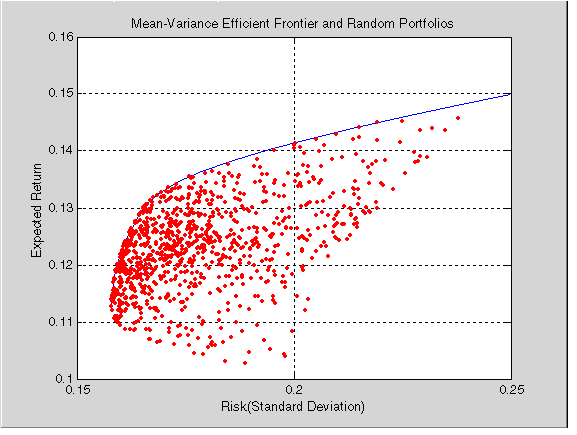

In [1]:
from IPython.display import Image
Image(filename='Efficient_Frontier.png') 

In the graph the x axis is the amount of risk and the y axis is the return. So intuitively being in the bottom right corner is very bad (high risk/ low returns) and being in the upper left is great! (low risk high rewards) Every red dot represents a single stock and what their past risk vs return. The blue line is what’s called the optimal frontier. This is just fancy speak for the best return you can make for an given amount of risk you can take. Markowitz showed that you can create this optimal portfolio by a linear combination of stocks. You may have heard of the term diversification when people talk about your 401k, this is what they are talking about. 

So what does this have to do with our hackathon or paper? Well when I was explaining this to you maybe you started to think, that somethings were rather…. Simplistic, or even a bit naive. For example, the only measure of risk is the variance of a stock’s past returns? Or simply you are going to model the returns by looking at an average? Perhaps you even noticed the more subtle point that when you take the covariance between stocks you are modeling similarity as a linear relationship. Or even that you are making assumptions about the returns are lognormal(usually you take log returns). That doesn’t seem like it is always going to be true! If you had these thoughts then it turns out you would be correct. But, I assure you from first hand experience in my many years on Wall Street, this is how it is done today in practice. (There are slight variations which take into account hand crafted factors such as Barra models but, that is out of scope)

Enter Deep Portfolio Theory: The way they authors differ from Markowitz is to start they take a series of returns and run them through an autoencoder. A simple explanation of an autoencoder is that it is a model that you feed in data and then you try to predict that same data. The caveat here being that you constrain this model in some way either by having a lower capacity than the data’s dimensions or by regularizing it in some way. The part before the bottleneck is called the encoder and the part after is called the decoder. I am a visual learner so the figure below helps.  

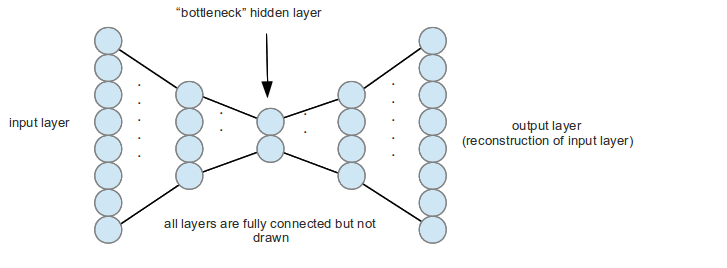

In [2]:
Image(filename='AutoencoderPicture.png') 

As you may have guessed both by the picture and Deep part of the title Deep Portfolio Theory they use a Neural Network as the autoencoder. In the paper they use 5 hidden units in one layer neural network and regularize the neural network with L2 regularization and a lambda factor that they tune in a validation stage. After they do this they look at the encodings and do a 2-norm on the embedding vectors and take the top ten most similar to minimize “mutual information” and then start adding other securities to see what the efficient frontier looks like. They go further and try to use it to track a benchmark….. blah blah blah.

The thing that is significant and the thing that you should take away from this is that they created an efficient frontier from data. Using a neural network with relu activations they allow for there to be nonlinear dependencies and learn the these nonlinear risk relationships between stocks from data. This is quite amazing and a potentially HUGE leap forward. 

## My Implementation 

I follow this paper very roughly. First of all I have spent 3 hours going through quantopian which gives huge amounts of minute by minute data for all stocks. The problem is they contain this information in a backtester so you can not get it out and their research environment does not support theano, tensorflow or keras…. F@!%. So due to lack of data, I manually scraped yahoo finance and got five years of historical data from five stocks: SPY,  JCP,  AAPL, GOOG, and XOM. 

The Data has to be normalized and partitioned for use in the autoencoder. So I drop columns that are not useful from the data and create rolling time series windows. Using a function I turn all the columns into return series. This code is not the most pretty/efficient I know! Its a HACKATHON get over it. Important to note that I create a 20 period window and then create another 20 period window that is only shifted by one. This introduces some autocorrelation in factors, but from experience this is preferable to the alternative which, creating time series that are bias by start data. Also, I will be shuffling these series and it provides more data to train on. 

In [3]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = pd.read_csv('SPY.csv')
data.iloc[0,2]

132.020004

In [5]:
# A function that normalizes all the sequences
def normalize_window(window_data):
    normalized_data =[]
    for window in window_data:
        window = window.drop(window.columns[[0]],axis=1)
        normalized_data.append(window.values/window.iloc[0].values-1)
    return normalized_data


def load_stock_data(ticker, sequence_length=20, train_split =0.8, val_test_split=0.5, peak=0):
    data = pd.read_csv(ticker + '.csv')
    result = []
    # here we rearrange the columns and get rid of the non_adjusted close
    data = data[data.columns[[0,1,2,3,6,5]]]
    
    #here we create a list of dataframes. that increment the day by one and and have sequence length sequence length
    # this is important because it then allows us to apply a function to each sequence to normalize it into return space
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #normalize the data and get the shape
    result = np.array(normalize_window(result))
    print("The shape of the whole dataset is: {}".format(result.shape))

    # get the row that splits test data from the rest
    train_row = int(round(train_split*result.shape[0]))

    # get the training set (note that this is not split X_train or Y_train yet because we only
    # care about the auto encoding and wont use this LSTM for prediction)
    train = result[:train_row,:]

    # Get the validation and testing portion of the data
    val_test = result[train_row:,:]

    #get the row we split test vs validation
    test_row =int(round(val_test_split*val_test.shape[0]))

    #get the validation set
    validation =val_test[:test_row,:]

    #get the test set
    test = val_test[test_row:,:]

    #now we print out the shape

    print("Training set shape: {}".format(train.shape))
    print("Validation set shape: {}".format(validation.shape))
    print("Test set shape: {}".format(test.shape))
    if peak ==1:
        print(data.head(3))
    return train, validation, test

Now I create train, validation, test sets for all of the tickers independently. I could use a flag but,  I am lazy. I will use them separately later so there is a point to this.

In [6]:
# GET ALL THE DATA FOR THE STOCKS
# Known bug: This could be done much better and faster. this is also not scalable to hundred of securities
# we want to keep them seperate though so we can test their embeddings seperately.
# also need to implement a check that the dimensions are the same for the data. right now you can just visually inspect

train_SPY, validation_SPY, test_SPY = load_stock_data('SPY',20, 0.8, 0.5)
train_GOOG, validation_GOOG, test_GOOG = load_stock_data('GOOG',20, 0.8, 0.5)
train_AAPL, validation_AAPL, test_AAPL = load_stock_data('AAPL',20, 0.8, 0.5)
train_JCP, validation_JCP, test_JCP = load_stock_data('JCP',20, 0.8, 0.5)
train_XOM, validation_XOM, test_XOM = load_stock_data('XOM',20, 0.8, 0.5,1)

The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
         Date       Open       High        Low    Volume  Adj Close
0  2012-05-21  81.419998  82.129997  81.070000  13730400  82.040001
1  2012-05-22  82.139999  82.839996  81.519997  13790000  81.949997
2  2012-05-23  81.790001  82.080002  79.959999  17582200  82.04000

Combine the individual ticker datasets together in their respective train, validation, test partitions.


In [7]:
train = np.concatenate((train_SPY,train_GOOG,train_AAPL,train_JCP,train_XOM), axis=0)
print('Shape of Total Train: {}'.format(train.shape))
validation = np.concatenate((validation_SPY,validation_GOOG,validation_AAPL,validation_JCP,validation_XOM), axis=0)
print('Shape of Total Validation: {}'.format(validation.shape))
test = np.concatenate((test_SPY, test_GOOG, validation_AAPL, test_JCP, test_XOM), axis=0)
print('Shape of Total Test: {}'.format(test.shape))

Shape of Total Train: (4950, 20, 5)
Shape of Total Validation: (620, 20, 5)
Shape of Total Test: (620, 20, 5)


## AUTOENCODERS

Here is where I start to get off script. I didn’t know what kind of NN for the autoencoder but, because the data is made up of timeseries (and I want to show of my mad DL skills) so I have decided to do both a fully connected autoencoder and an LSTM autoencoder. Below are my two autoencoders.

### LSTM AUTOENCODER 

In [8]:
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model


# This change of variables names is just to help me with understanding the network
# NOTE: LATENT_DIM IS A HYPERPARAMETER I PICKED 5 BECAUSE OF THE PAPER
timesteps = train.shape[1] #this is the sequence_length
input_dim = train.shape[2] # this is the number of parameters the stock has
latent_dim = 7

# My inputs
inputs = Input(shape=(timesteps, input_dim))
# They get encoded into a certain latent dimension
encoded = LSTM(latent_dim)(inputs)

#we then take the encoded vector and run it through another lstm
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

#we put it together in a single model
sequence_autoencoder = Model(inputs, decoded)

#create an incoder
encoder = Model(inputs, encoded)

# I TRIED TO CREATE A DECODER BUT I FAILED. TO DO create a decoder
# create a placeholder for an encoded (5-dimensional) input
#encoded_input = Input(shape=(latent_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = sequence_autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

Using TensorFlow backend.


### Fully-Connected Autoencoder (RAN OUT OF TIME TO TEST THIS)

I ran this and it works but, i didnt have time to analyze it. It is also set up very stupidly becuase I used the same variable names for both encoders. Thus i can only use one at a time. I would like to redo this but, too late.

In [ ]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## Yeah I'll get a little fancy for you.

So…… here is the other thing. You may have noticed if you were looking at  my code and the dimensions of my data that I have three dimensions to each of my stocks dataframes. The last dimension has a length of five…. well the truth is because I don’t have enough data to make a true portfolio I feel like I need to do something a little different. What I decided is that while its cool to look at risk relationships in terms of some nonlinear combination of returns, what if you throw in some other information as well? This was not really possible in the markowitz framework but, this is deep learning BABY! We are creating parameters learned from data we just throw in what data we want. I decided to include not only the returns from close of business to close of business but, also the returns from the highs of the day, the lows of the day, the open of day, and even the changes in the volume of stock traded. Ok lets check it out. Here I am feeding the autoencoder my data.

### run the autoencoder

In [9]:
from keras.callbacks import TensorBoard
n_epochs = 350
batch_size=64

sequence_autoencoder.compile(optimizer='RMSprop', loss='mean_squared_error')

sequence_autoencoder.fit(train, train,
                epochs=n_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(validation, validation),
                verbose=0,
                callbacks=[TensorBoard(log_dir='/tmp/lstmautoencoder',histogram_freq=5,
                                      write_images=True,
                                      embeddings_freq=5)])

INFO:tensorflow:Summary name lstm_1/kernel:0 is illegal; using lstm_1/kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/kernel:0 is illegal; using lstm_1/kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/recurrent_kernel:0 is illegal; using lstm_1/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/recurrent_kernel:0 is illegal; using lstm_1/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/bias:0 is illegal; using lstm_1/bias_0 instead.
INFO:tensorflow:Summary name lstm_1/bias:0 is illegal; using lstm_1/bias_0 instead.
INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/bias:0 is il

And thats all there is to it! The network is built and trained! lets take a look at it.

## Training and Visualizing the Network 

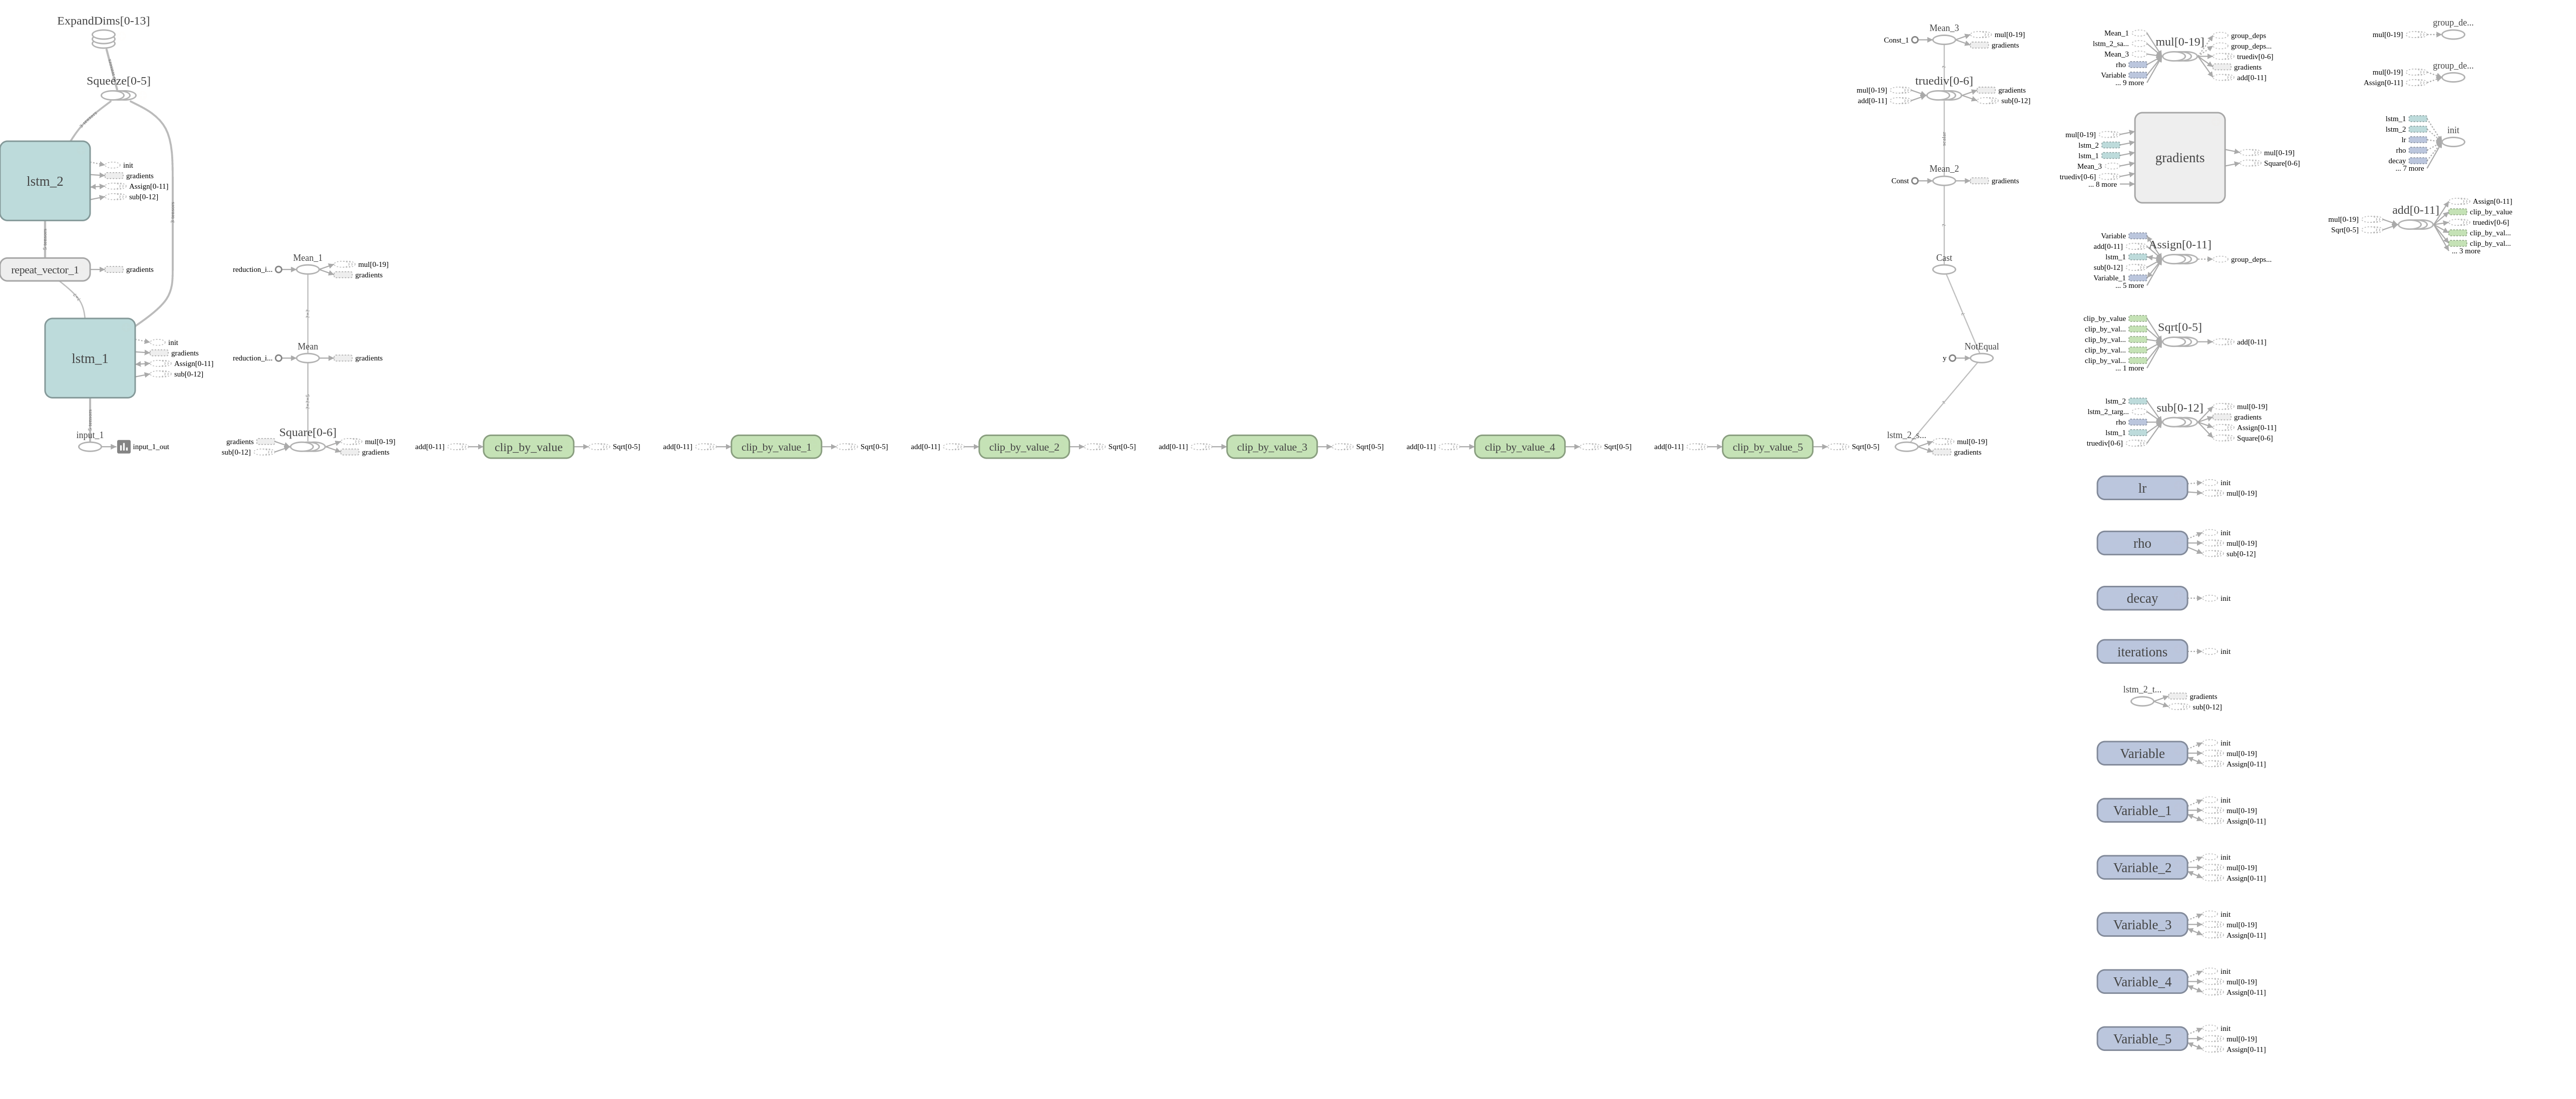

In [20]:
Image(filename='graph-run=.png') 

MAN THAT IS A SWEET NETWORK!!! Ok, I know its actually very small and pretty ugly but, that is how it looks in tensorboard so I had to show it off. 

So before we get into the analysis and looking at what our autoencoder learned I want to make a few comments on the hyperparameters. 

Loss: MSE
So for the loss function I chose MSE. The reason for this is that I wanted to penalize errors farther away much more harshly. Also, due to the fact that these are timeseries that we are trying to model I felt that MSE was an appropriate loss to use. 

Optimizer: RMSprop
For the optimizer I used RMSprop. This choice was simply based on my own experience, emperically I have found that RMSprop works well for RNNs.

Batch size: 64
During training I experimented with a batch size of 32 and 64 and found no real difference. I wound up sticking with 64 because it was the last thing I tried and I didnt think it was necessary to rerun the network again. 

n_epochs: 350
Initially I started trainging with 100 epochs but, as you can see from the Tensorboard graph below the validation loss keeps dropping for after this point so I raised the n_epochs to 350 for my final run. You can see that validation is still dropping even after 350 but, that was all the time I had to run this.

Latent Dim: 7
This is the parameter I would be most excited about varying and playing around with in the future. There is no good reason for trying the number 7. I just picked a number small enough to be managable but, large enough that I thought it could capture some interesting information. every input has 20 timesteps with 5 dimensions, this is 100 datapoints that are compressed down to 7. This means that our network has a compression factor of 14.3:1. 

Finally, I want to comment on my use of Keras as opposed to building the network all in straight tensorflow. The fact is Keras is a great way to prototype. I needed to do this project quickly and Keras gets you 99% of the way there in 2% of the time. While building an LSTM or autoencoder from scratch is a great learning exercise for implementation Keras is simply the easiest way to go. For examples of my work building RNN's and NNs from scratch please look at my github.

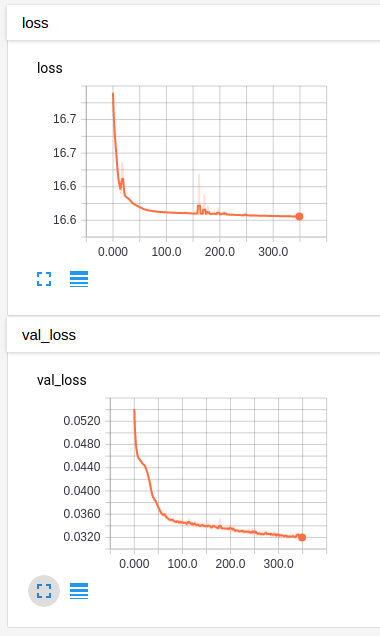

In [12]:
Image(filename='tensorboard_loss.png')

Below are some histograms of the lstm parameters during training. At the back is the distribution at the beginning of training and in the front is the distribution after 350 epochs. As you can see for this parameter it appears to be converging

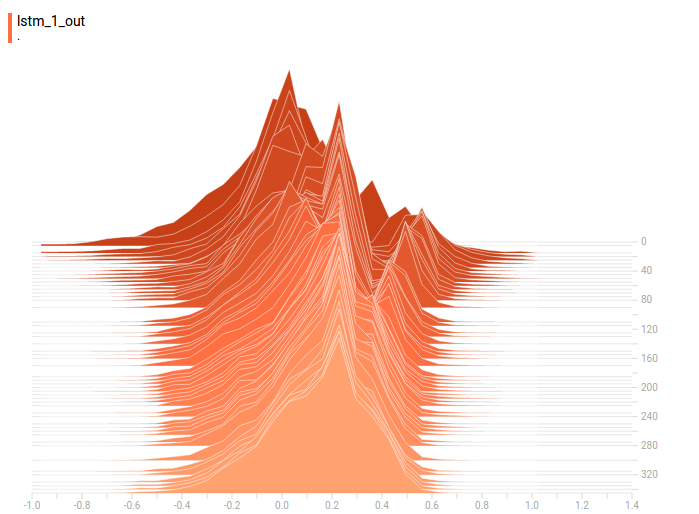

In [14]:
Image(filename='LSTM_1_hist.png')

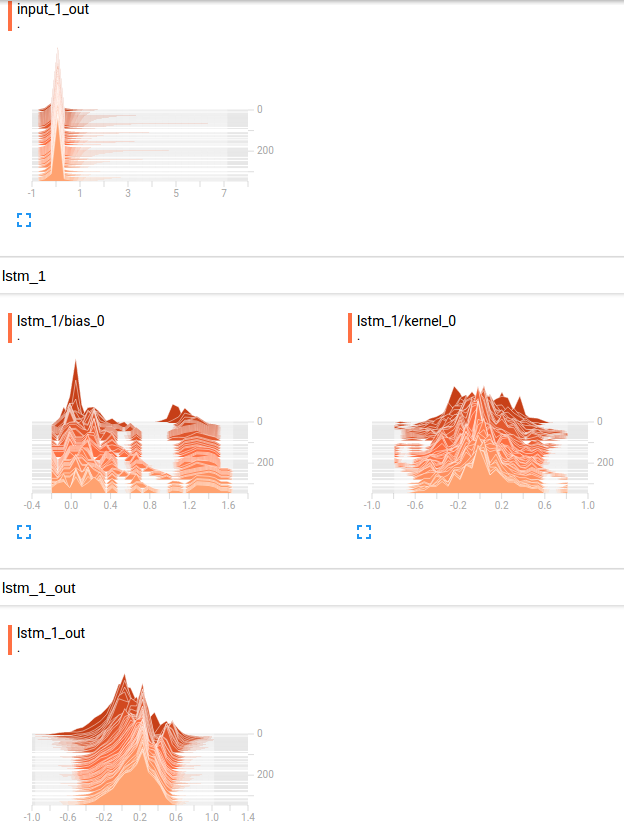

In [16]:
Image(filename='all_lstm_1.png')

The bias parameter looks a little funky and doesnt look like it is converging. Honestly, I am not sure if this is normal or not. Perhaps this is something I can speak to experts about at insights fellowship if I am admitted ; -)

##  Analysis

Now for the really fun part, looking at the results.

I always find it somewhat disappointing when I finish training a deep learning model. You put in all this work to get the data, clean the data, build the model, train the model then then, at the end, there is just a blank jupyer notebook staring you back in the face. I feel like this should be the champagne moment where magic should be happening and cool graphs and amazingness should burst out of your screen. You know there is just so much cool stuff trapped in your computer but, now you have to build more machinery to visualize and see if we got anything good. Anyways, on with it.

So first and foremost lets take a look at how well the network is able to reconstruct itself.

In [21]:
''' This is where my real sloppiness in the beginning is bitting me in the ass when it comes to managing my data
 I knew this was coming but, i was too anxious and pressed for time to do it right in the beginning so now i employ
 even more hacks'''
ticker_list =['SPY','GOOG','AAPL','JCP', 'XOM']
val_data = [validation_SPY,validation_GOOG,validation_AAPL,validation_JCP,validation_XOM]


Here we are creating plots to look at our predictions. We grab 10 sequences at random from the validation set 
plot them against what the autoencoder reconstructs. Some of these examples you can see do a very good job 
at getting the average values and general shape of the time series correct. However the predictionsare all very
smoothed. This is as we would expect since we know that autoencoders are very good at noise reduction.In general one property that is nice is the slope of the ts is correct.

One thing to note is that we have 5 features, I will try to visualize them all together in a stock barchart format later if i have time. For now i will just look at the predicted returns of the close price. The graphs below the blue lines are the actual returns and the orange lines are the reconstruction from the autoencoder.

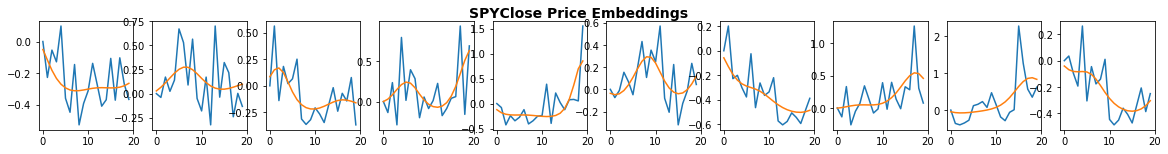

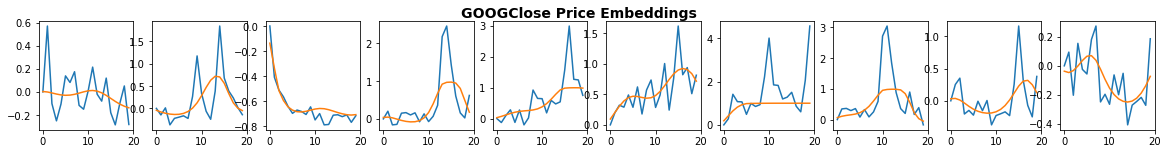

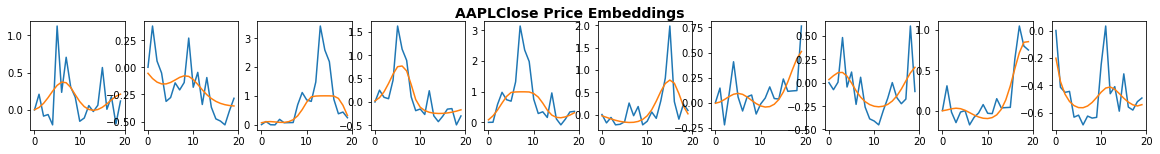

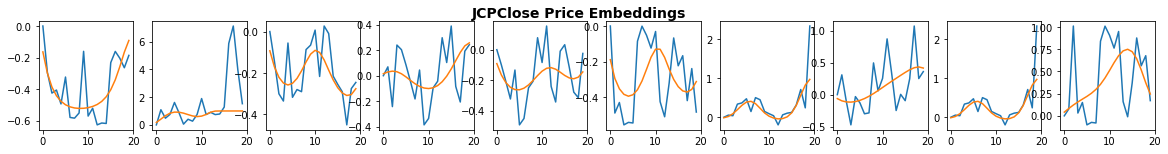

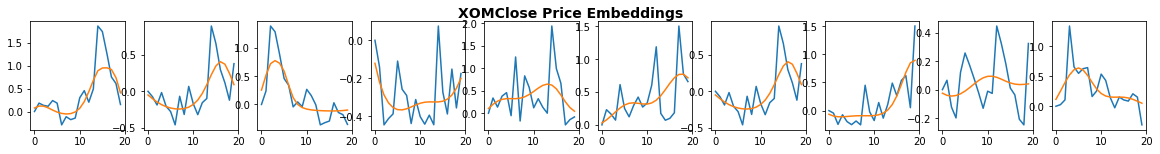

In [27]:
'''Here we are creating plots to look at our predictions. We grab 10 sequences at random from the validation set 
    plot them against what the autoencoder reconstructs. Some of these examples you can see do a very good job 
    at getting the average values and general shape of the time series correct. However the predictionsare all very
    smoothed. This is as we would expect since we know that autoencoders are very good at noise reduction.In general
    one property that is nice is the slope of the ts is correct.'''
for num, stock_name in enumerate(ticker_list):
    j = 10
    plt.figure(figsize=(20, 2))
    plt.suptitle(stock_name+'Close Price Embeddings', fontsize=14, fontweight='bold')

    for i in range(j):
        n =np.random.randint(low=0,high=val_data[num].shape[0])
        ax = plt.subplot(1, j, i+1)
        plt.plot(np.array(range(val_data[num][n,:,3].shape[0])),val_data[num][n,:,3],np.array(range(val_data[num][n,:,3].shape[0])),sequence_autoencoder.predict(val_data[num])[n,:,3])
    plt.show()
#n=2

WOW, look at that. The embeddings have definitely learned something. We know that embeddings are good for denoising and it is very evident that the reconstruction is far less noisy than the original series. The remarkable thing to me is that it has clearly learned distinct features of the time series in only 7 features. You can see that it has determined overall shape and fit quite nicely. It has clearly learned some nonlinear relationships which was exatly the idea. Keep in mind that this is done in the validation set now, not in the trainset so it is not simply a case that it has memorized the data. 

So, this is for the close price, now lets take a look at the other features. I am just going to run a for loop over the features so we should get a whole mess of graphs (250 to be precise)

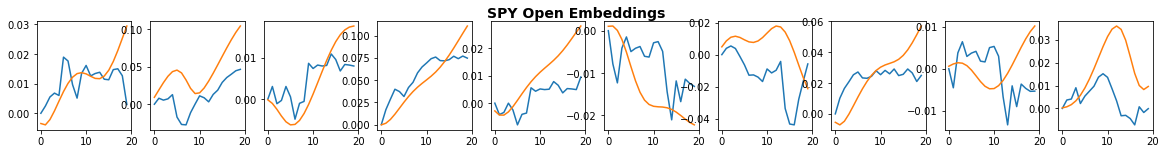

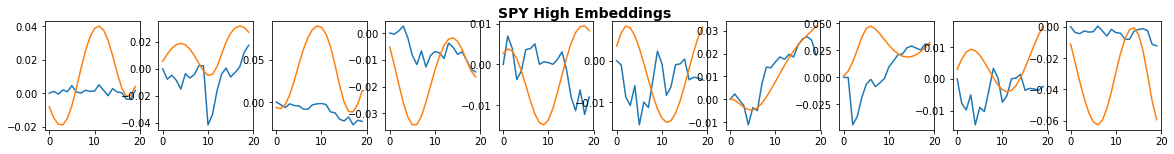

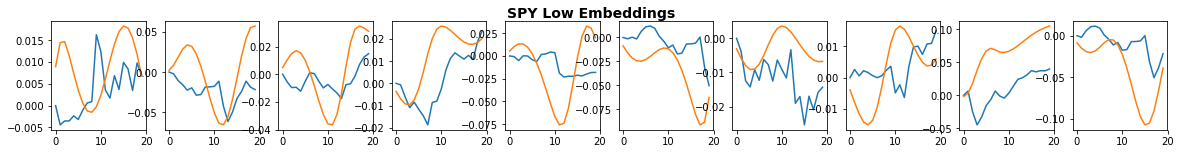

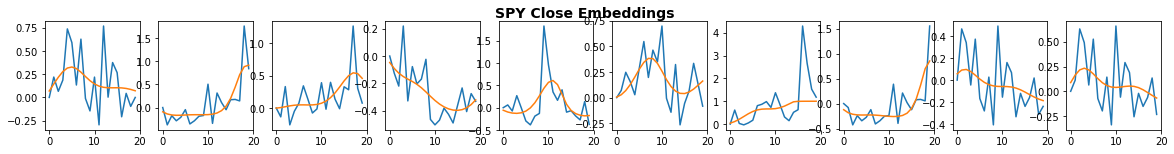

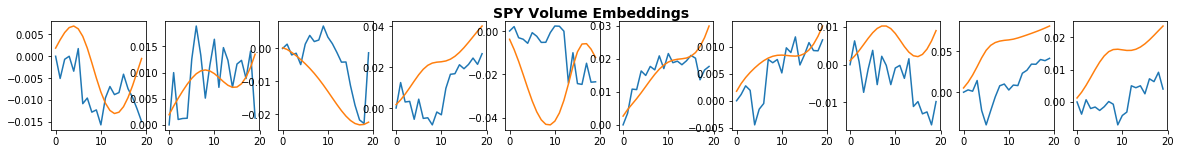

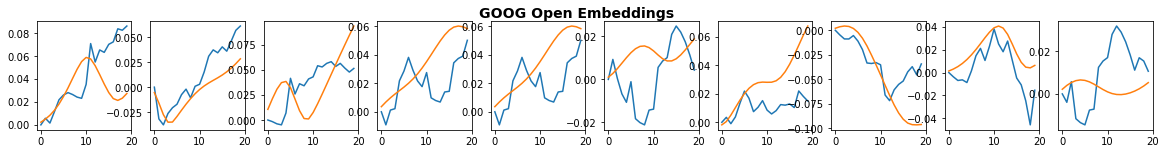

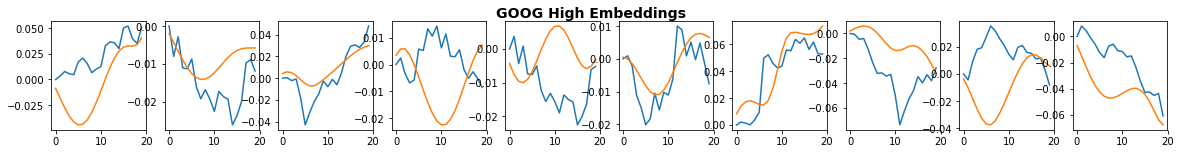

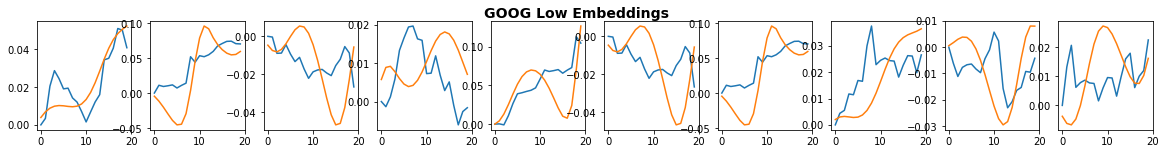

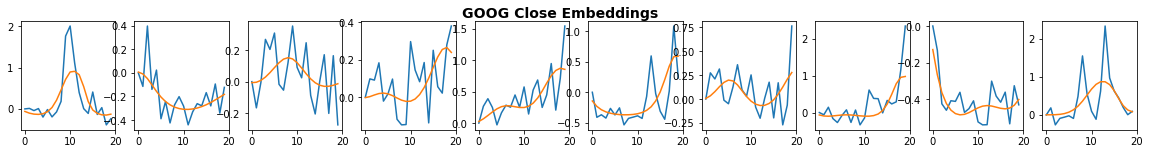

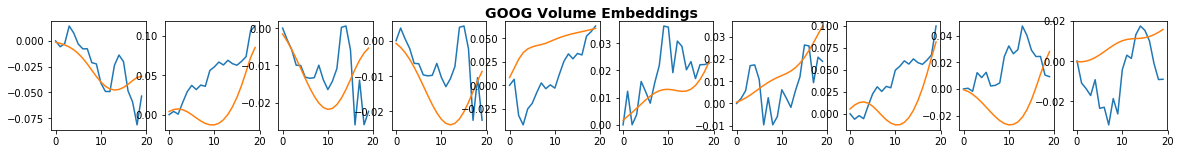

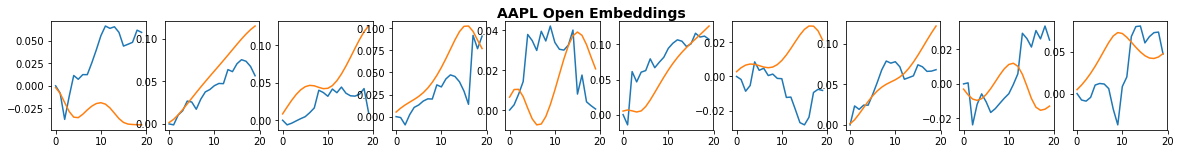

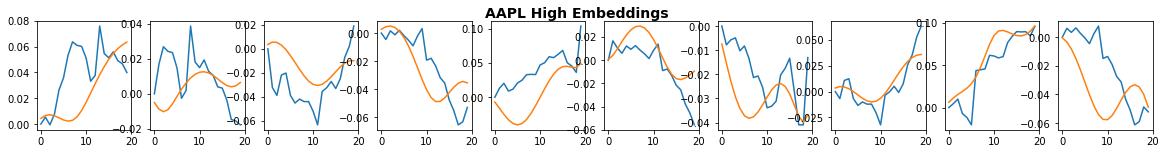

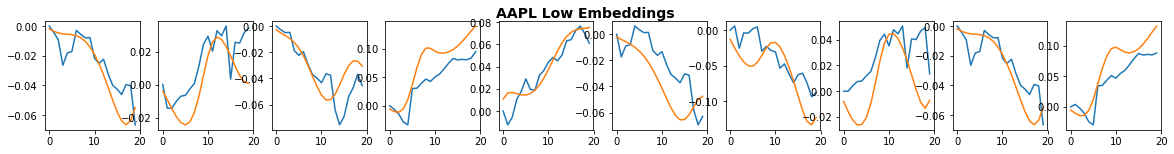

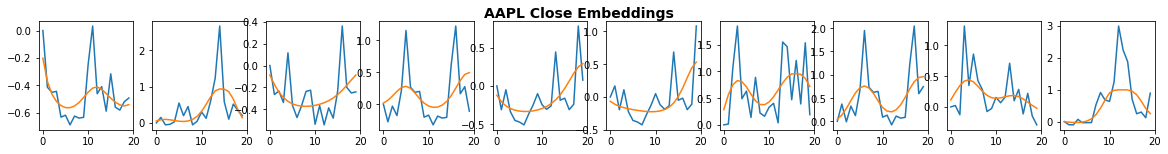

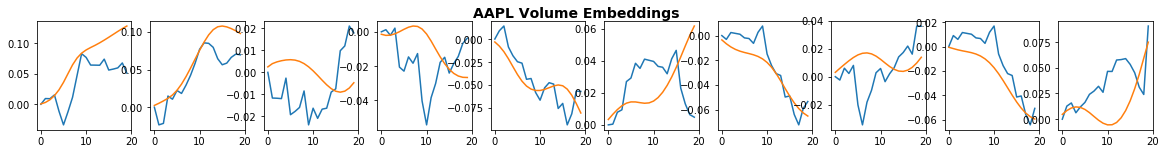

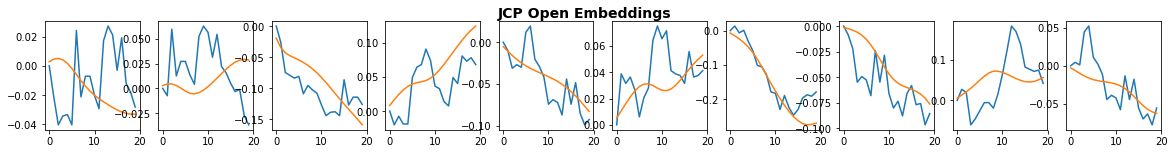

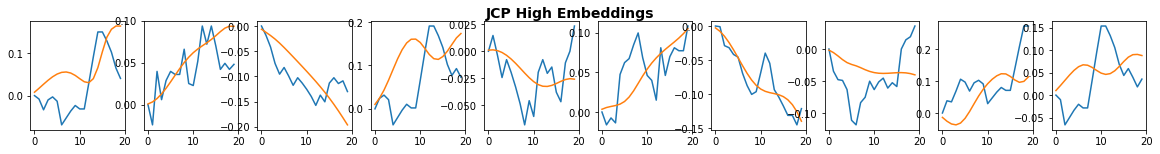

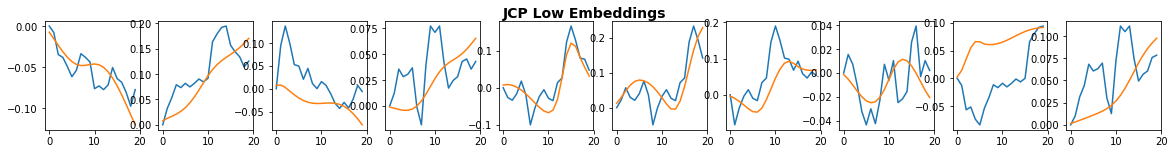

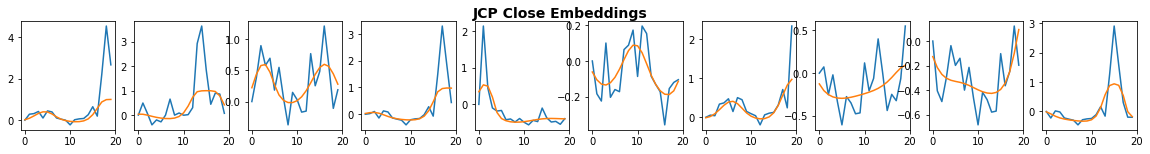

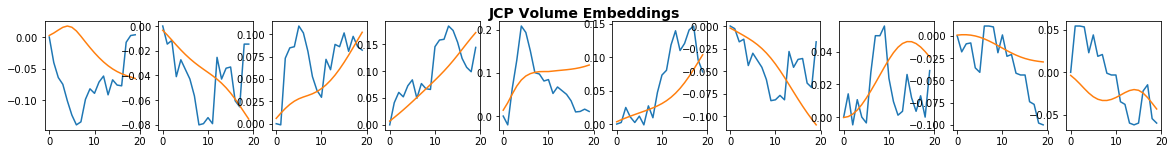

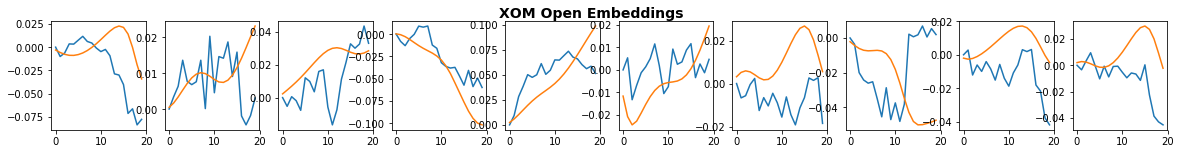

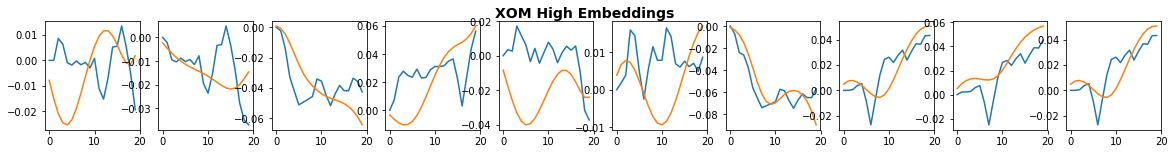

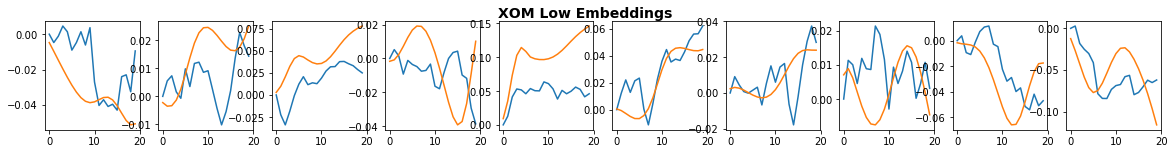

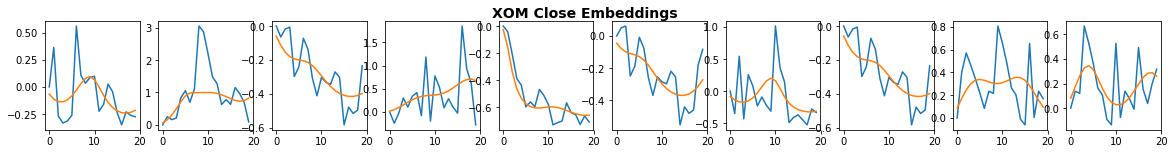

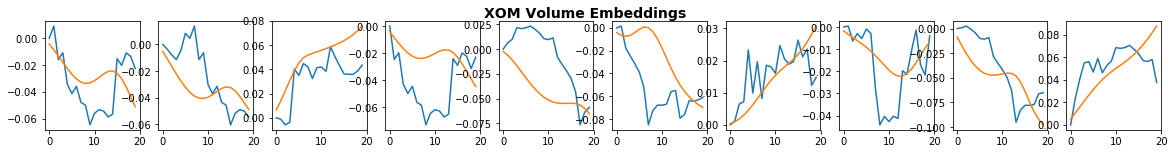

In [30]:
features = ['Open', 'High', 'Low','Close','Volume']

for num, stock_name in enumerate(ticker_list):
    for n_feature, feature in enumerate(features):
        j = 10
        plt.figure(figsize=(20, 2))
        plt.suptitle(stock_name+' '+feature+' Embeddings', fontsize=14, fontweight='bold')

        for i in range(j):
            n =np.random.randint(low=0,high=val_data[num].shape[0])
            ax = plt.subplot(1, j, i+1)
            plt.plot(np.array(range(val_data[num][n,:,n_feature].shape[0])),
                     val_data[num][n,:,n_feature],
                     np.array(range(val_data[num][n,:,n_feature].shape[0])),
                     sequence_autoencoder.predict(val_data[num])[n,:,n_feature])
        plt.show()

Well, that is interesting. It appears to have learned the features but, the closing price best of all. This is not what I would have expected. To get more insights I suggest we look at the features of the embedding seperately. 

## The Encodings - digging deeper 

First thing I will do is try to visualize the embeddings for all the stocks in the validation period. I am going to do this by encoding all the time series and running them in a T-SNE and mapping them to two dimensions. The idea is that hopefully when we map this into a lower order space we can find clusters, perhaps we can identify the security by its embedding. ( I really don't this this will work and I think the logic behind it is flawed but, lets see)

In [43]:
targets=[]
for i, ticker in enumerate(ticker_list):
    targets += [i]*val_data[i].shape[0]
    
targets = np.array(targets)
targets.shape

(620,)

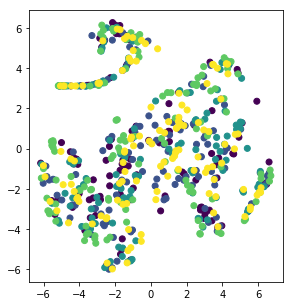

In [44]:
''' Here I attempt to visualize the factors that we have learned from the autoencoder. I have chosen 7 hidden units
so we have 7 different dimensions in order to be able to visualize this more easily i use the t-sne algorithm
to map them into 2d space. This plot does not show much. But, that is not very un reasonable. To properly look at
the factors we should break them up by stock, and by time frame. Factors generally float overtime so it would be
more interesting to see how they change. We also would like to have a larger universe of stocks instead of only 5'''
from sklearn.manifold import TSNE

X_tsne = TSNE(learning_rate=50).fit_transform(encoder.predict(validation))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=targets)

Yup, nothing useful. Very pretty, but useless. There is an ex-girlfriend joke that practically writes itself here but, I will take the high road... 

So, the reason I kinda expected this is because the task of identifying a security using only a 20 day price and volume return profile is almost impossible even for experienced professionals. Furthermore, from the reconstructions above, we get a sense that the embeddings learned more about the structure of the timeseries itself than anything stock specific. This also makes sense as an lstm is just a mathematical tool and we really just fed it time series data and trained it to miminize MSE not to try to classify stocks.

Next, lets take a look at each of the 7 features individually. What I am going to plot is a time series of how an individual factor changes over time. This would be equivalent to looking back 20 days, embedding the timeseries, visualizing a certain factor and then doing it again the next day. The reason this is a good thing to look at is becasue it will tell us how stable the feature is. Also, in practice this is how you would have to use a model like this. You would train it, then fit and refit for a given time period. (to be explored is the optimal hyperparameter for how often you refit and retrain but, that is out of scope for the context of this project.

### Factor #1 

In [73]:
factor1 =[]
for i in range(len(ticker_list)):
    factor1.append(encoder.predict(val_data[i])[:,0])

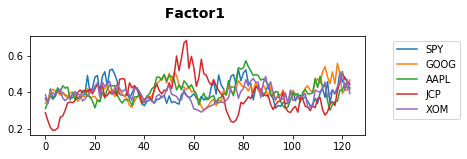

In [72]:
fig = plt.figure() #Creates a new figure
ax1 = fig.add_subplot(211)

for i in range(len(factor1)):
    plt.suptitle(' Factor1', fontsize=14, fontweight='bold')
    ax1.plot(factor1[i], label = ticker_list[i])

leg = plt.legend( loc = 'upper right')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax1.transAxes)

# Change to location of the legend. 
xOffset = .3
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax1.transAxes)

plt.show()

That still doesnt tell us a whole lot. Lets look at them spread out over individual graphs

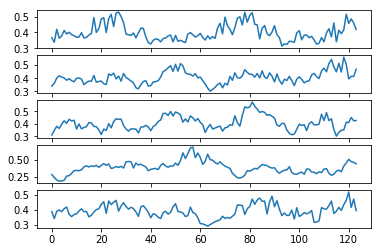

In [74]:
f, axes = plt.subplots(len(factor1), 1)

for i in range(len(factor1)):
    axes[i].plot(factor1[i])

It is hard to tell anything still because we don't know if that is stable or not. What we can see though is that it has jumps which appear to be rather significant. If it was changing incredibly slowly you would expect to see somethign smooth like a moving average. I am not seeing this. Because it looks at the shape for a 20 day period, perhaps it would be useful to look at the timeseries of a single stock price over time plotted against the factor. So lets do that

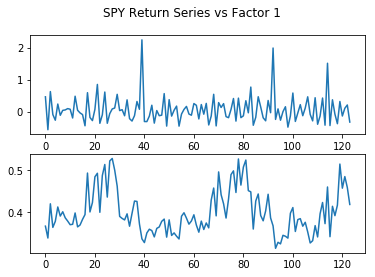

In [81]:
f, axes = plt.subplots(2, 1)
plt.suptitle('SPY Return Series vs Factor 1')
axes[0].plot(val_data[0][:,1,3])
axes[1].plot(factor1[0])
plt.show()

### All the factors

It appears that we need a better way of visualizing our factors. The graph above looks at our returns over time vs our first factor. Again it doesnt really tell us much. The next thing I propose is to look at a spider plot for every time step. This will tell us how strongly the encodings are activated in 7 dimensions. We can also compare them to the other stocks

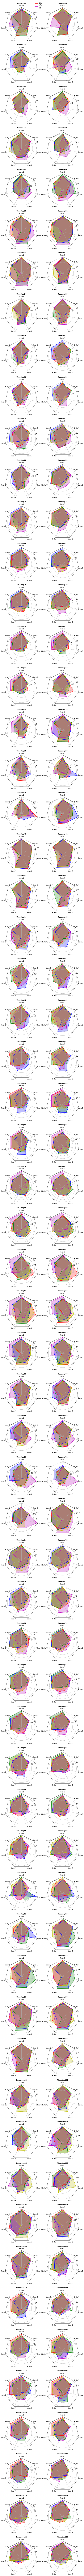

In [211]:
from plotting_utils import radar_factory
from plotting_utils import transform_data
from plotting_utils import radar_factory
N = 7
theta = radar_factory(N, frame='polygon')

data = transform_data(val_data,ticker_list)
spoke_labels = data.pop(0)

fig, axes = plt.subplots(figsize=(9, 9), nrows=62, ncols=2,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
fig.set_figheight(300)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids(a)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
ax = axes[0, 0]
labels = ('SPY', 'GOOG', 'AAPL', 'JCP', 'XOM')
legend = ax.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '7-Factors of 5 Stocks',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()

Wow that is a lot of plots. But the reason I think this is useful is it allows us to visually inspect the features and look for annomolies. For example, look at timestep 37. It is interesting that SPY factor 6 is EXTREMELY high especially compared to other stocks. What I wonder now is, what about the timeseries in SPY is factor6 detecting that is not prevalent in any other stock. For that I have made the wonderful function below to look at all the features timeseries from that time step over all the stocks. 

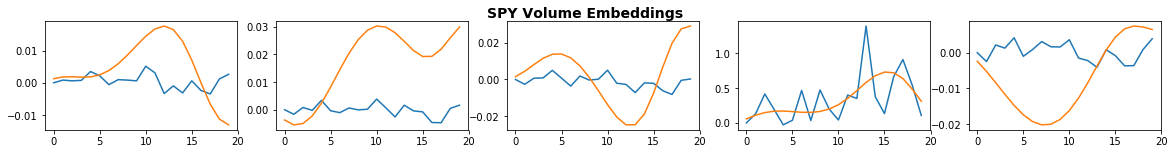

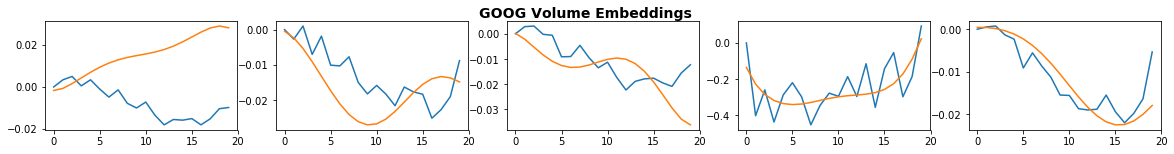

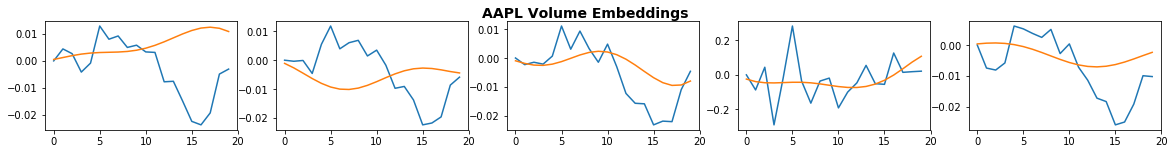

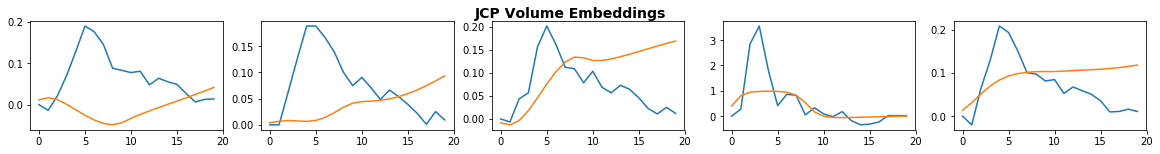

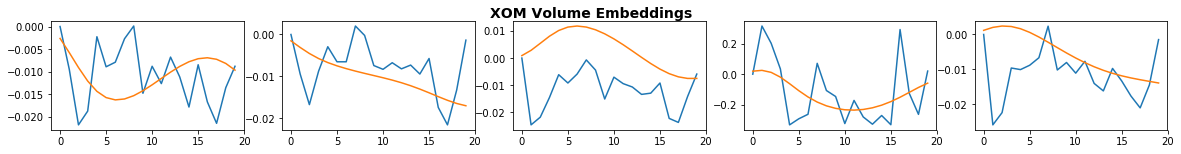

In [200]:
time_step=71

features = ['Open', 'High', 'Low','Close','Volume']
n = time_step


for num, stock_name in enumerate(ticker_list):
    plt.figure(figsize=(20, 2))
    plt.suptitle(stock_name+' '+feature+' Embeddings', fontsize=14, fontweight='bold')
    j=len(features)
    for n_feature, feature in enumerate(features):
        ax = plt.subplot(1, j, n_feature+1)
        plt.plot(np.array(range(val_data[num][n,:,n_feature].shape[0])),
                 val_data[num][n,:,n_feature],
                 np.array(range(val_data[num][n,:,n_feature].shape[0])),
                 sequence_autoencoder.predict(val_data[num])[n,:,n_feature])
    plt.show()


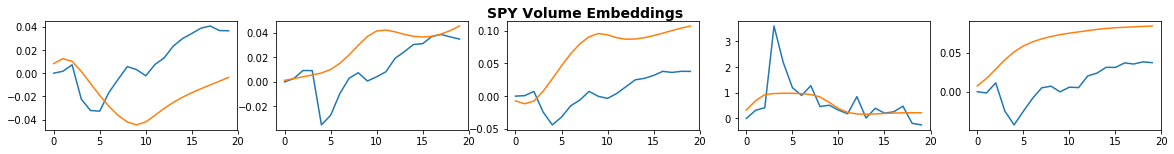

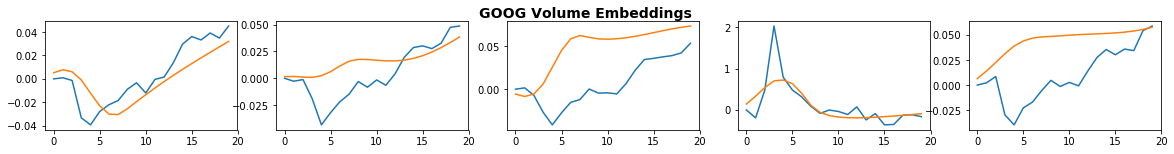

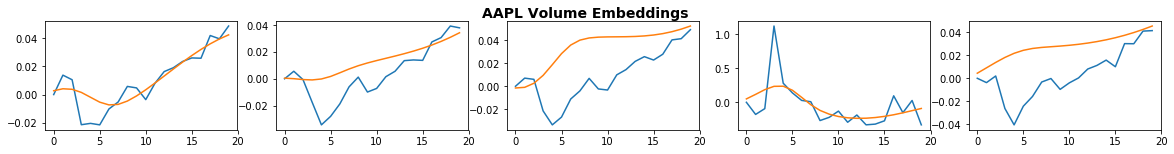

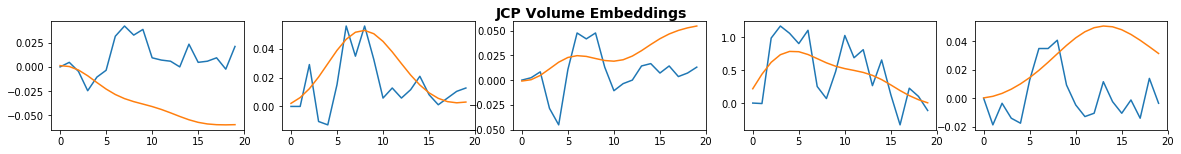

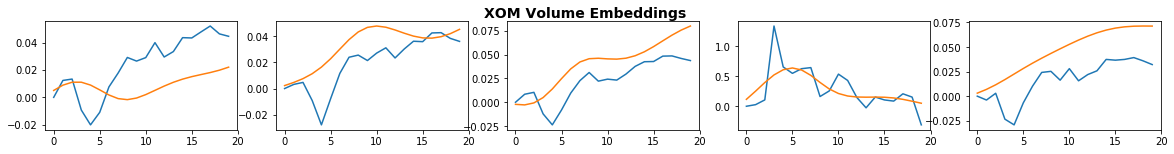

In [201]:
time_step=37

features = ['Open', 'High', 'Low','Close','Volume']
n = time_step


for num, stock_name in enumerate(ticker_list):
    plt.figure(figsize=(20, 2))
    plt.suptitle(stock_name+' '+feature+' Embeddings', fontsize=14, fontweight='bold')
    j=len(features)
    for n_feature, feature in enumerate(features):
        ax = plt.subplot(1, j, n_feature+1)
        plt.plot(np.array(range(val_data[num][n,:,n_feature].shape[0])),
                 val_data[num][n,:,n_feature],
                 np.array(range(val_data[num][n,:,n_feature].shape[0])),
                 sequence_autoencoder.predict(val_data[num])[n,:,n_feature])
    plt.show()

So it turns out it would have been more useful to create a tool that took 2 timesteps and two tickers and just compared the features for those. I have implemented that below. So looking at time step 71 which factor 6 has a high activation for JCP and 37 which factor 6 is high for SPY we can see that in both cases the shapes of their timeseries features look similar. In feature1 (open price returns) they both have this shallow U shape going upwards. You an also see that in feature 3 they both have this increasing almost decaying log type slope with a bump in it. 

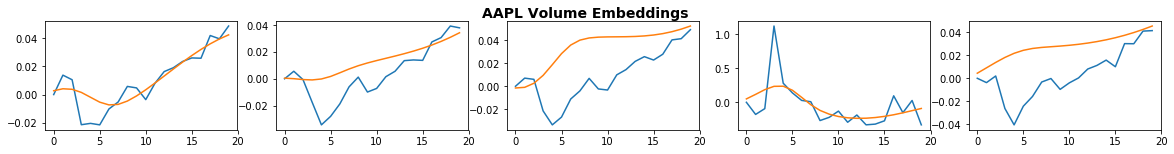

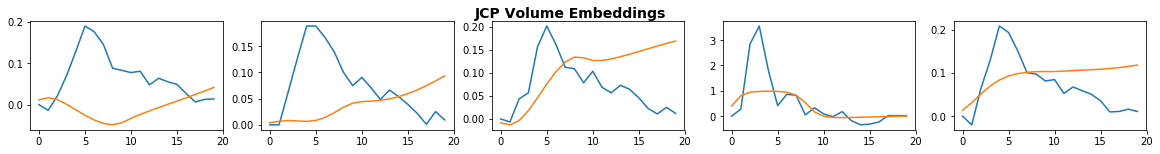

In [205]:

# here you can play around by just changing the time/ticker combinations and it will print out all the features for
# that pair. for example this looks at aapl timestep37 aand jcp time step 71
time_ticker1 =(37,'AAPL')
time_ticker2 = (71, 'JCP')


####### DONT MODIFY BELOW HERE
time_tick=[time_ticker1, time_ticker2]

features = ['Open', 'High', 'Low','Close','Volume']

ticker_to_num ={'SPY':0,'GOOG':1,'AAPL':2,'JCP':3,'XOM':4}

for tt in time_tick:
    stock_name = tt[1]
    num = ticker_to_num[stock_name]
    plt.figure(figsize=(20, 2))
    n=tt[0]
    plt.suptitle(stock_name+' '+feature+' Embeddings', fontsize=14, fontweight='bold')
    j=len(features)
    for n_feature, feature in enumerate(features):
        ax = plt.subplot(1, j, n_feature+1)
        plt.plot(np.array(range(val_data[num][n,:,n_feature].shape[0])),
                 val_data[num][n,:,n_feature],
                 np.array(range(val_data[num][n,:,n_feature].shape[0])),
                 sequence_autoencoder.predict(val_data[num])[n,:,n_feature])
    plt.show()

# FACTOR CONCLUSIONS 

I am running out of time and I have not gotten to some of the things I wanted to so I want to explain where this analysis fits in with our original discussion of the work on deep portfolio theory. Creating an autoencoder was the first step in the paper. I have impemented this but, instead of moving onto portfolio theory I have deviated and taken I have taken a deep dive into what the factors are actually encoding. One of the reasons for doing this is that currently I do not have enough data, on enough different stocks to create any meaningfully balanced portfolio. 

While, I have not come to any solid conclusions on what exactly all of the specific factors encode, what I have shown is that they appear to describe the shapes of the timeseries. Something interesting to try from here would be to see if any of the factors are predictive of future returns. Furthermore, in adding volume, high, low, open and close data to the encodings it would be interesting to see how that would effect deep portfolio theory. My hypothesis is that the more data you put in the better you would be able to model the similarities. The next step which I will jot down below is to begin ranking the similarity of these embeddings. This will then be used similarly to how markowitz used the covariance matrix in assessing risk. We can then optimize the weights of the portfolio in order to create an efficient frountier or a portfolio that performs better under different scenarios. 